# Lab 6. RNN

In [9]:
import math
%matplotlib inline

# imports 
import torch
from torch import nn
from torch.nn.functional import cross_entropy

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Lambda, Compose

import numpy as np
import matplotlib.pyplot as plt 
from typing import Tuple, Optional

In [10]:
transforms = Compose([ToTensor(), Lambda(lambda x: x.reshape(28, 28))])

train_data = MNIST(root='.', train=True, transform=transforms, download=True)
test_data = MNIST(root='.', train=False, transform=transforms)

## Zadanie 1.


In [11]:



class RNN(nn.Module):
    
    def __init__(self, 
                 input_size: int,
                 hidden_size: int, 
                 output_size: int):
        """
        :param input_size: int
            Dimensionality of the input vector
        :param hidden_size: int
            Dimensionality of the hidden space
        :param output_size: int
            Desired dimensionality of the output vector
        """
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size

        self.input_to_hidden = nn.Linear(self.input_size, self.hidden_size)
        self.hidden_to_output = nn.Linear(self.hidden_size, self.output_size)
    
    # for the sake of simplicity a single forward will process only a single timestamp 
    def forward(self, 
                input: torch.tensor, 
                hidden: torch.tensor) -> Tuple[torch.tensor, torch.tensor]:
        """
        :param input: torch.tensor 
            Input tesnor for a single observation at timestep t
            shape [batch_size, input_size]
        :param hidden: torch.tensor
            Representation of the memory of the RNN from previous timestep
            shape [batch_size, hidden_size]
        """
        
        hidden = torch.tanh(self.input_to_hidden(input)) +  hidden
        hidden.retain_grad()
        output = torch.tanh(self.hidden_to_output(hidden))
        
        return output, hidden
    
    def init_hidden(self, batch_size: int) -> torch.Tensor:
        """
        Returns initial value for the hidden state
        """
        return torch.zeros(batch_size, self.hidden_size, requires_grad=True)

### Pętla uczenia

In [13]:
torch.manual_seed(1337)
batch_size = 50

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

rnn = RNN(28, 64, 10)
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)   

epochs = 1
grads = []

for epoch in range(epochs):
    for i, (x, y) in enumerate(train_loader):  
        hiddens = []
        optimizer.zero_grad()
        hidden = rnn.init_hidden(x.shape[0])
        hidden.retain_grad()
        seq_len = x.shape[1]
        outputs = []
        
        for j in range(seq_len):
            output_part, hidden = rnn(x[:, j], hidden)
            hiddens.append(hidden)
            outputs.append(output_part)
            
        output = sum(outputs)
            
        loss = cross_entropy(output, y)
        loss.backward(retain_graph=True)
        optimizer.step()  
        grads.append([np.linalg.norm(h.grad.numpy()) for h in hiddens])
        
        if i % 100 == 0:
            print(f"Epoch: {epoch} Iter: {i}/{len(train_loader)} Loss: {loss}")

with torch.no_grad():
    correct = 0
    for i, (x, y) in enumerate(test_loader):
        hidden = rnn.init_hidden(x.shape[0])
        seq_len = x.shape[1]
        outputs = []
        
        for j in range(seq_len):
            output_part, hidden = rnn(x[:, j], hidden)
            outputs.append(output_part)
            
        output = sum(outputs)
        pred = output.argmax(dim=1)
        correct += int(sum(pred == y))
        
    accuracy = correct / (batch_size * len(test_loader))

    print(f"Final Accuracy: {accuracy}")
    assert accuracy > 0.4, "Subject to random seed you should get over 0.4 accuracy, try changing the seed!"

Epoch: 0 Iter: 0/1200 Loss: 15.616976737976074
Epoch: 0 Iter: 100/1200 Loss: 2.2864644527435303
Epoch: 0 Iter: 200/1200 Loss: 2.2868306636810303
Epoch: 0 Iter: 300/1200 Loss: 2.2111856937408447
Epoch: 0 Iter: 400/1200 Loss: 1.9884696006774902
Epoch: 0 Iter: 500/1200 Loss: 2.0003013610839844
Epoch: 0 Iter: 600/1200 Loss: 1.8152750730514526
Epoch: 0 Iter: 700/1200 Loss: 1.2142670154571533
Epoch: 0 Iter: 800/1200 Loss: 1.5686267614364624
Epoch: 0 Iter: 900/1200 Loss: 1.629099726676941
Epoch: 0 Iter: 1000/1200 Loss: 1.4679745435714722
Epoch: 0 Iter: 1100/1200 Loss: 1.5452572107315063
Final Accuracy: 0.4754


## Zadanie 2

<BarContainer object of 28 artists>

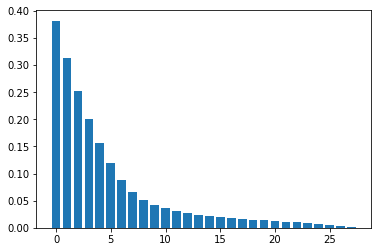

In [14]:
# mean_grads in assume to be a 1D array or list of average gradients norm per timestep memory 
grads = np.array(grads)
mean_grads = grads.mean(axis=0)
plt.bar(x=np.arange(len(mean_grads)), height=mean_grads)

## Zadanie 3

In [3]:
class LSTMCell(nn.Module):

    def __init__(self, 
                 input_size: int, 
                 hidden_size: int):
        """
        :param input_size: int
            Dimensionality of the input vector
        :param hidden_size: int
            Dimensionality of the hidden space
        """
        
        super(LSTMCell, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.input_to_hidden = nn.Linear(self.input_size, 4 * self.hidden_size)
        self.hidden_to_hidden = nn.Linear(self.hidden_size, 4 * self.hidden_size)
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, 
                input: torch.tensor, 
                states: Tuple[torch.tensor, torch.tensor]) -> Tuple[torch.tensor, torch.tensor]:
        
        hidden, cell = states     
        gates = self.input_to_hidden(input) + self.hidden_to_hidden(hidden)
        gates = gates.squeeze()
        in_gate, forget_gate, cell_gate, out_gate = gates.chunk(4, 1)
        
        in_gate = torch.sigmoid(in_gate)
        forget_gate = torch.sigmoid(forget_gate)
        cell_gate = torch.tanh(cell_gate)
        out_gate = torch.sigmoid(out_gate)
       
        cell = torch.mul(cell, forget_gate) + torch.mul(in_gate, cell_gate)   
        hidden = torch.mul(out_gate, torch.tanh(cell))
        return hidden, cell

### Klasa modelu LSTM

In [5]:
class LSTM(nn.Module):

    def __init__(self, 
                 input_size: int, 
                 hidden_size: int):
        """
        :param input_size: int
            Dimensionality of the input vector
        :param hidden_size: int
            Dimensionality of the hidden space
        """
        
        super(LSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.cell = LSTMCell(input_size=input_size, hidden_size=hidden_size)
        
    def forward(self, 
                input: torch.tensor) -> Tuple[torch.tensor, torch.tensor]:
        """
        :param input: torch.tensor 
            Input tesnor for a single observation at timestep t
            shape [batch_size, input_size]
        Returns Tuple of two torch.tensors, both of shape [seq_len, batch_size, hidden_size]
        """
        
        batch_size = input.shape[0]
        seq_len = input.shape[1]
        
        initial_states = self.init_hidden_cell(batch_size)
        
        hiddens = []
        cells = []
        
        hidden, cell = initial_states
        
        for i in range(seq_len):
            hidden, cell = self.cell(input[:, i], (hidden, cell))
            hiddens.append(hidden)
            cells.append(cell)
       
        return hiddens, cells
    
    def init_hidden_cell(self, batch_size):
        """
        Returns initial value for the hidden and cell states
        """
        return (torch.zeros(batch_size, self.hidden_size, requires_grad=True), 
                torch.zeros(batch_size, self.hidden_size, requires_grad=True))

### Pętla uczenia

In [8]:
from itertools import chain

torch.manual_seed(1337)

batch_size = 50

# build data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# initialize the lstm with an additional cliassifier layer at the top
lstm = LSTM(input_size=28, hidden_size=64)
clf = nn.Linear(in_features=64, out_features=10)

# initialize a optimizer
params = chain(lstm.parameters(), clf.parameters())
optimizer = torch.optim.Adam(params, lr=0.01) 

# we will train for only a single epoch 
epoch = 1

# main loop
for epoch in range(epoch):
    for i, (x, y) in enumerate(train_loader):        
        optimizer.zero_grad()
        outputs = []
        
        hiddens, cells = lstm(x)
        for hidden in hiddens:
            outputs.append(clf(hidden))
        output = sum(outputs)
        
        loss = cross_entropy(output, y)
        loss.backward()
        optimizer.step()                                
        
        if i % 100 == 0:
            print(f"Epoch: {epoch} Iter: {i}/{len(train_loader)} Loss: {loss:.4f}")

# evaluate on the test set
with torch.no_grad():
    correct = 0
    for i, (x, y) in enumerate(test_loader):
        outputs = []
        
        hiddens, cells = lstm(x)
        for hidden in hiddens:
            outputs.append(clf(hidden))
        output = sum(outputs)

        pred = output.argmax(dim=1)
        correct += int(sum(pred == y))
    
    accuracy = correct / (batch_size * len(test_loader))
    
    print(f"Final Accuracy: {accuracy}")
    assert accuracy > 0.9, "Subject to random seed you should get over 0.9 accuracy, try changing the seed!"

Epoch: 0 Iter: 0/1200 Loss: 4.0775
Epoch: 0 Iter: 100/1200 Loss: 0.7015
Epoch: 0 Iter: 200/1200 Loss: 0.2582
Epoch: 0 Iter: 300/1200 Loss: 0.0782
Epoch: 0 Iter: 400/1200 Loss: 0.1317
Epoch: 0 Iter: 500/1200 Loss: 0.2103
Epoch: 0 Iter: 600/1200 Loss: 0.1869
Epoch: 0 Iter: 700/1200 Loss: 0.2880
Epoch: 0 Iter: 800/1200 Loss: 0.0197
Epoch: 0 Iter: 900/1200 Loss: 0.0418
Epoch: 0 Iter: 1000/1200 Loss: 0.0572
Epoch: 0 Iter: 1100/1200 Loss: 0.0556
Final Accuracy: 0.9666
